## Intensity filtered data using reference aluminium wavelength 309.506 (pixel number 445) using saturated data

### No preprocessing

In [1]:
import os
from sys import stdout
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.linear_model import ElasticNet,ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    
    return
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
"""   
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        plt.show()
    return
""" 

"   \n    # Fit a line to the CV vs response\n    z = np.polyfit(y, y_c, 1)\n    with plt.style.context(('ggplot')):\n        fig, ax = plt.subplots(figsize=(9, 5))\n        ax.scatter(y_c, y, c='red', edgecolors='k')\n        #Plot the best fit line\n        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)\n        #Plot the ideal 1:1 line\n        ax.plot(y, y, color='green', linewidth=1)\n        plt.title('$R^{2}$ (CV): '+str(score_cv))\n        plt.xlabel('Predicted $^{\\circ}$Brix')\n        plt.ylabel('Measured $^{\\circ}$Brix')\n        plt.show()\n    return\n"

In [3]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
    Xc = X[:,sorted_ind]
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [4]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [5]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

In [211]:
x_df = pd.read_csv('../avg_base_wl_snv_25-02.csv', sep = ',')
values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

#print(values)
#print(type(values))
print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(24, 1446)
(1446,)
24


,252.071400,252.201700,252.331900,252.462200,252.592400,252.722600,252.852900,252.983100,253.113300,253.243600,...,428.718100,428.828600,428.939000,429.049500,429.159900,429.270300,429.380600,429.491000,429.601300,429.711600
0,-0.344373,-0.347848,-0.356285,-0.336970,-0.344718,-0.345358,-0.338137,-0.330733,-0.340345,-0.350320,...,-0.321401,-0.273034,-0.144126,-0.190786,-0.299305,-0.334805,-0.352164,-0.359186,-0.361609,-0.355506
1,-0.331948,-0.331135,-0.350940,-0.313899,-0.324499,-0.334414,-0.315240,-0.299210,-0.320002,-0.338570,...,-0.281239,-0.312536,-0.322072,-0.325885,-0.310323,-0.306443,-0.332467,-0.340004,-0.352265,-0.343401
2,-0.316908,-0.324266,-0.341452,-0.309906,-0.321354,-0.326369,-0.317708,-0.300467,-0.317540,-0.329811,...,-0.289282,-0.315080,-0.317742,-0.320883,-0.303575,-0.306108,-0.325849,-0.332131,-0.336727,-0.332763
3,-0.320763,-0.324743,-0.340930,-0.306270,-0.322093,-0.330264,-0.316338,-0.300945,-0.316683,-0.328896,...,-0.288779,-0.313351,-0.310556,-0.317370,-0.301713,-0.308997,-0.330248,-0.338553,-0.345427,-0.337869
4,-0.257611,-0.272147,-0.280917,-0.248740,-0.258642,-0.248205,-0.217025,-0.218065,-0.254277,-0.282762,...,-0.274140,-0.294377,-0.309811,-0.301654,-0.285431,-0.290359,-0.304597,-0.310613,-0.315817,-0.308232
5,-0.246829,-0.266995,-0.274410,-0.235297,-0.246313,-0.239514,-0.203933,-0.209955,-0.250532,-0.275219,...,-0.261778,-0.278668,-0.275235,-0.277841,-0.273974,-0.278110,-0.297093,-0.302152,-0.305797,-0.298854
6,-0.321088,-0.324756,-0.347113,-0.303429,-0.316149,-0.328773,-0.311197,-0.300478,-0.322428,-0.342807,...,-0.275019,-0.313151,-0.322668,-0.320948,-0.301506,-0.299824,-0.326682,-0.337254,-0.343319,-0.335544
7,-0.338385,-0.344020,-0.354033,-0.327717,-0.341875,-0.341969,-0.330092,-0.322204,-0.335513,-0.349084,...,-0.311578,-0.334135,-0.335348,-0.331987,-0.325251,-0.329479,-0.342420,-0.351520,-0.357780,-0.352164
8,-0.325957,-0.337818,-0.344187,-0.318387,-0.323686,-0.318377,-0.299514,-0.297178,-0.318066,-0.337669,...,-0.321543,-0.339093,-0.341076,-0.343046,-0.335158,-0.335725,-0.346081,-0.346704,-0.352875,-0.346137
9,-0.295092,-0.314320,-0.317703,-0.280862,-0.289242,-0.275467,-0.239035,-0.243018,-0.287212,-0.311163,...,-0.321946,-0.338760,-0.344441,-0.344280,-0.334111,-0.333293,-0.341996,-0.348871,-0.351804,-0.346273


[252.0714 252.2017 252.3319 ... 429.491  429.6013 429.7116]


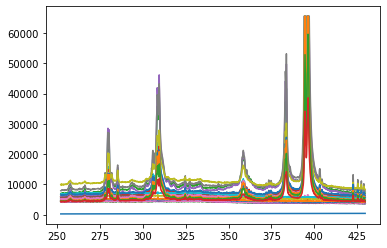

In [145]:
#This is just for visualizing the various plots of the samples

df = pd.read_csv('../ref_new/1.csv')
data=df.values
wl= data[0]
print(wl)

for i in range(len(values)):
    plt.plot(wl, data[i,:])
    #plt.show() #comment this one to have unique plot instead of multiple ones
#range(len(dfs))
#"""



In [146]:
df_y = pd.read_csv('../concentration_1.csv', sep = ',')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

y_values=df_y.values
y_all=pd.DataFrame(y_values[:,1:-2])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(24, 9)


,Reference Number,Si,Fe,Mg,Zn,Cu,Mn,Al,Total
0,1,0.185,0.228,2.940,0.0304,0.0620,0.280,96.0000,99.7254
1,2,0.360,0.600,1.100,0.0700,0.2000,0.830,96.5787,99.7387
2,3,9.140,1.010,0.200,0.4200,3.6000,0.410,84.7770,99.5570
3,4,8.565,0.000,0.293,0.8870,2.6360,0.330,86.5650,99.2760
4,5,9.500,0.000,0.391,0.0000,0.0580,0.016,90.0210,99.9860
5,6,7.220,0.140,0.360,0.0840,0.1200,0.053,91.8090,99.7860
6,7,7.460,0.530,0.036,0.1400,0.1500,0.100,91.4140,99.8300
7,8,12.900,0.120,0.520,0.1550,0.5200,0.286,84.7905,99.2915
8,9,8.750,0.460,1.710,0.0290,2.0000,0.056,85.3100,98.3150
9,10,0.260,0.420,1.260,0.0200,0.0040,1.160,96.8346,99.9586


In [147]:
y_val = concentration[:,5] #1-Si, 2-Fe, 3-Mg, 5-Cu, 6-Mn (4-Zn but too much sparse)
print(y_val)
print(y_val.shape)
y_df= pd.DataFrame(y_val)
#y_df

[6.200e-02 2.000e-01 3.600e+00 2.636e+00 5.800e-02 1.200e-01 1.500e-01
 5.200e-01 2.000e+00 4.000e-03 6.000e-02 1.100e-01 5.400e-03 5.600e-02
 6.000e-03 5.000e-02 4.290e+00 3.100e+00 1.900e+00 5.700e-03 6.000e-03
 1.600e+00 1.500e-01 1.350e+00]
(24,)


### Wavelength subset selection

For Silicon (Si) the peaks are at **251.59, 288.12, 390.60**

For Magnesium (Mg) the peaks are at **277.91, 279.59, 280.23, 281.78, 383.74, 285.27**

For Manganese (Mn) the peaks are at **292.83, 293.61, 294.91, 403.25, 404.63, 404.56**

For Copper (Cu) the peaks are at **296.06,324.73, 327.37**

In [148]:
print(wl.T)
print(wl.shape)
#print(len(wl))
print(wl[0])
print(wl[-1])

[252.0714 252.2017 252.3319 ... 429.491  429.6013 429.7116]
(1446,)
252.0714
429.7116


In [149]:
#target = [251.59, 288.12, 390.60] #peaks for Si
#target = [277.91, 279.59, 280.23, 281.78, 383.74, 285.27] #peaks for Mg
#target = [292.83, 293.61, 294.91, 403.25, 404.63, 404.56] #peaks for Mn
#target= [296.06,324.73, 327.37] #peaks for Cu
#target= [330.14, 334.41] #peaks for Zn
#target= [310.03, 312.69, 404.63, 426.17, 373.69, 372.03, 373.43, 257.67, 259.36, 259.90, 274.89, 356.94, 363.04] #Fe
target = [251.59, 288.12, 390.60, 277.91, 279.59, 280.23, 281.78, 383.74, 285.27, 292.83, 293.61, 294.91, 403.25, 404.63, 404.56, 296.06,324.73, 327.37, 330.14, 334.41, 310.03, 312.69, 404.63, 426.17, 373.69, 372.03, 373.43, 257.67, 259.36, 259.90, 274.89, 356.94, 363.04]
len(target)

33

In [150]:
a = []
b = []
for t in target:
    for i in range(len(wl)):
        if abs(wl[i]-t) < 0.1:
            a.append(wl[i])
            b.append(i)
            
print("number of selected wavelengths: ",len(a), "\n")
print(a, "\n")
print(b)

number of selected wavelengths:  39 

[288.1042, 390.5023, 390.6203, 277.9076, 279.5883, 280.2344, 281.7845, 383.7444, 285.2688, 292.7366, 292.8651, 293.6362, 294.9207, 403.2452, 404.6329, 404.5174, 404.6329, 296.0762, 324.7267, 327.3745, 330.1431, 334.4105, 310.0156, 312.6889, 404.6329, 426.1698, 373.676, 371.9858, 372.1066, 373.4347, 257.669, 259.3599, 259.88, 274.8022, 274.9316, 356.875, 356.9978, 362.9976, 363.1196] 

[278, 1102, 1103, 199, 212, 217, 229, 1045, 256, 314, 315, 321, 331, 1211, 1223, 1222, 1223, 340, 565, 586, 608, 642, 449, 470, 1223, 1413, 961, 947, 948, 959, 43, 56, 60, 175, 176, 823, 824, 873, 874]


In [151]:
print(values.shape)
print(values[:, b].shape)
x_selecta = pd.DataFrame(values[:, b])
x_selecta

(24, 1446)
(24, 39)


,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.003660,0.035492,0.034897,0.051578,0.186989,0.183790,0.048129,0.406657,0.075721,0.009270,...,0.027418,0.023243,0.002472,0.002539,-0.002138,-0.002144,0.034106,0.036362,0.020372,0.023274
1,0.000791,0.017037,0.016885,0.020633,0.112001,0.097276,0.027951,0.119272,0.047514,0.002167,...,0.013296,0.018804,0.005505,0.003031,-0.002137,-0.001987,0.033161,0.030514,0.015142,0.018184
2,-0.000844,0.019732,0.019319,0.009333,0.074919,0.058032,0.032227,0.051853,0.031268,0.003907,...,0.004643,0.019778,0.005834,0.002429,-0.002811,-0.003243,0.038647,0.037476,0.021771,0.022490
3,-0.000744,0.020428,0.019670,0.017589,0.104164,0.089821,0.029682,0.098886,0.043288,0.002911,...,0.009708,0.019336,0.005517,0.002588,-0.002041,-0.002463,0.030870,0.029521,0.013510,0.016137
4,0.049460,0.038793,0.040405,0.009716,0.072009,0.055866,0.027895,0.059984,0.030784,0.002345,...,0.004994,0.016140,0.000837,0.001778,-0.001956,-0.002341,0.021055,0.021552,0.014088,0.015455
5,0.052395,0.037946,0.039329,0.000346,0.009464,0.006200,0.024587,0.012944,0.006586,0.002279,...,0.007692,0.016341,0.000697,0.001428,-0.001857,-0.002087,0.021754,0.022597,0.015245,0.016531
6,0.001436,0.016428,0.014528,0.017338,0.107509,0.089910,0.037362,0.085126,0.040286,0.002331,...,0.008681,0.016101,0.000638,0.002275,-0.002217,-0.002388,0.034250,0.034180,0.028801,0.031063
7,0.004077,0.024493,0.023826,0.052589,0.152126,0.154037,0.041893,0.416528,0.063906,0.008335,...,0.010210,0.016504,0.001756,0.001753,-0.002335,-0.002416,0.023581,0.024320,0.016371,0.017856
8,0.026040,0.032229,0.032181,0.020125,0.125565,0.106020,0.043789,0.112744,0.046763,0.005258,...,0.031452,0.019110,0.000885,0.003533,-0.002474,-0.002264,0.047042,0.050601,0.036553,0.039314
9,0.066787,0.050920,0.052041,0.012603,0.094113,0.074842,0.040339,0.084076,0.037203,0.004852,...,0.040265,0.021046,0.002128,0.004028,-0.002237,-0.002116,0.050995,0.054064,0.035707,0.039612


In [88]:
#X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 33) (19, 1)
(5, 33) (5, 1)
        0
11  0.110
22  0.150
7   0.520
3   2.636
23  1.350


# Principal Components Analysis

In [70]:
n_components=15


x = x_df.values
x= x_selecta.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

principalComponents = pca.fit_transform(X_std)
print(principalComponents.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(pca.singular_values_)

(24, 33)
(33,)
24
(24, 15)
[58.23 85.47 93.97 97.35 98.35 98.93 99.35 99.57 99.72 99.8  99.86 99.9
 99.93 99.95 99.97]


In [71]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(principalComponents, y_df)
# Calibration
y_c = regr.predict(principalComponents)
# Cross-validation
y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_df, y_c)
score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation

mse_c = mean_squared_error(y_df, y_c)
mse_cv = mean_squared_error(y_df, y_cv)

print(score_c, score_cv)
print(mse_c, mse_cv)

0.6695528517590783 -8.157565901969674
0.5517803169913743 15.291294366305811


now using PCA with Linear regression and PLS

In [72]:
n_components=15

x = X_train.values
x_t = X_test.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
X_std_test = StandardScaler().fit_transform(x_t)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

x_pc = pca.fit_transform(X_std)
x_test1 = pca.transform(X_std_test)
print(x_pc.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

(19, 33)
(33,)
19
(19, 15)
[58.4  85.43 94.36 97.94 98.72 99.3  99.6  99.75 99.84 99.89 99.93 99.96
 99.97 99.98 99.99]


In [73]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(x_pc, y_train)
# Calibration
y_p = regr.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_p)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_p)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  -12.01557251662706
MSE:  24.361497311561845


37% completed
Suggested number of components:  1



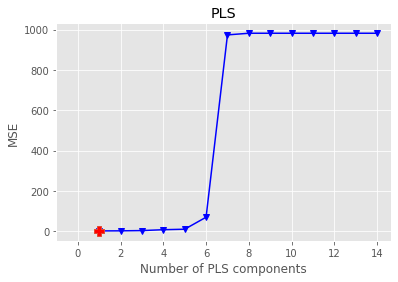

R2 calib: 0.892
R2 CV: -0.386
MSE calib: 0.175
MSE CV: 2.240


In [74]:
optimise_pls_cv(x_pc, y_train, 15, plot_components=True) 

In [75]:
pls = PLSRegression(n_components=3)
# Fit
pls.fit(x_pc, y_train)
# Calibration
y_c = pls.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_c)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_c)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  -12.015572516627147
MSE:  24.361497311562008


# Linear Regression
this is ordinary least square regression

R^2_pred:  -6.838277685607542
RMSE:  3.371022453515389 

[real, predictions]
[[ 0.062      -3.53634053]
 [ 0.06        4.00095887]
 [ 0.0057      1.89600296]
 [ 3.1         5.17820628]
 [ 1.35       -3.17189826]]


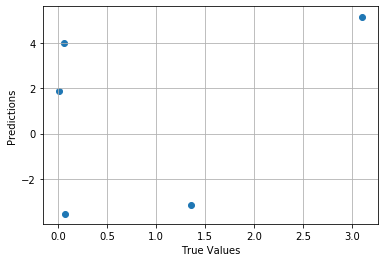

In [85]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("R^2_pred: ", r2)
print("RMSE: ", rmse, "\n")


b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Partial Least Square Regression

## No preprocessing

In [77]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)
y_test

(19, 33) (19, 1)
(5, 33) (5, 1)


,0
7,0.520
13,0.056
23,1.350
14,0.006
5,0.120


100% completed
Suggested number of components:  2



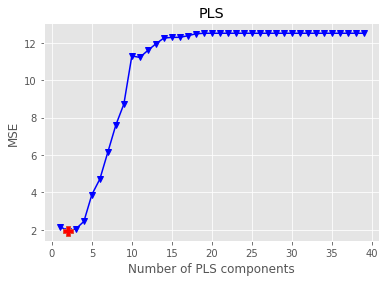

R2 calib: 0.325
R2 CV: -0.159
MSE calib: 1.127
MSE CV: 1.936


In [78]:
optimise_pls_cv(x_df, y_df, 40, plot_components=True)
#optimise_pls_cv(x_df, y_all, 40, plot_components=True)

In [79]:
# Define PLS object
pls = PLSRegression(n_components=3)
# Fit
pls.fit(x_df, y_df)
# Cross-validation
y_cv = cross_val_predict(pls, x_df, y_df, cv=10)
# Calculate scores
score = r2_score(y_df, y_cv)
mse = mean_squared_error(y_df, y_cv)

print("R^2_cv", score)
print("MSE: ", mse)

R^2_cv -0.22485326177653908
MSE:  2.045258749088161


In [80]:
#optimise_pls_cv(X_train,y_train, 40, plot_components=True)

R2_pred:  -13.174062956345608
R2_cv:  -6.847169094465631

TEST
 [real, predictions]
[[ 0.52       -1.61173569]
 [ 0.056      -0.09275242]
 [ 1.35       -0.88937182]
 [ 0.006       2.89369402]
 [ 0.12        0.35962275]]



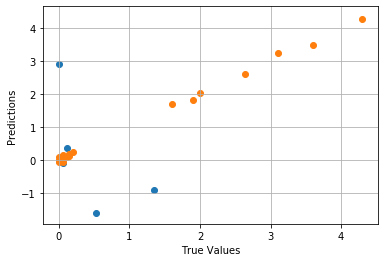

In [81]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [82]:
print(wl.shape)

(1446,)


## Wavelenght selection for PLS

In [89]:
print("x_selecta shape: ", x_selecta.shape)
start_time = time.time()

#opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_val, 15)
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_selecta.values, y_val, 25)

print("--- %s seconds ---" % (time.time() - start_time))

x_selecta shape:  (24, 33)
100% completed
Optimised number of PLS components:  2
Wavelengths to be discarded  30
Optimised MSEP  1.738419915961155

--- 5.672206401824951 seconds ---


In [90]:
#print(opt_Xc.shape,"\n")
#print("sorted indexes: ", sorted_ind)
print("sorted wavelengths: ", wl[sorted_ind[:10]].T)

#plt.plot(opt_Xc.T)
#plt.show()

sorted wavelengths:  [253.8946 254.4154 252.2017 255.4568 252.3319 254.155  254.2852 255.7171
 254.0248 255.8473]


In [91]:
X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 3) (19, 1)
(5, 3) (5, 1)
         0
17  3.1000
3   2.6360
13  0.0560
21  1.6000
12  0.0054


7% completed
Suggested number of components:  1



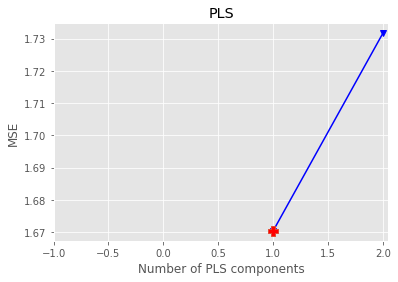

R2 calib: 0.119
R2 CV: -0.061
MSE calib: 1.387
MSE CV: 1.670


In [92]:
optimise_pls_cv(X_train,y_train, 3, plot_components=True)

R2_pred:  0.08817104202085069
RMSE:  1.221175648744552

TEST
 [real, predictions]
[[3.1        1.29596495]
 [2.636      0.74295026]
 [0.056      0.05702369]
 [1.6        0.86177547]
 [0.0054     0.27594306]]



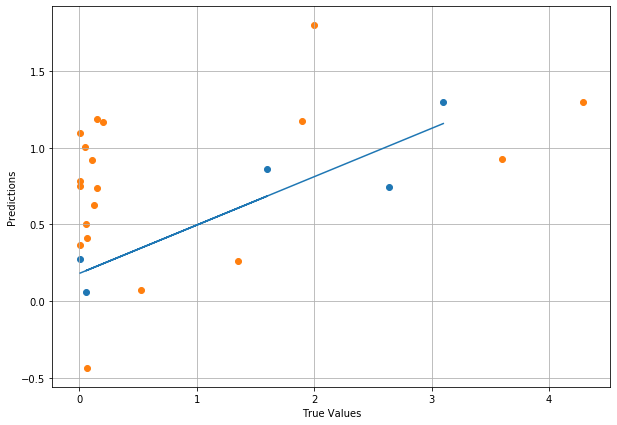

In [94]:
# Define PLS object
pls = PLSRegression(n_components=3)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Normalization

In [95]:
Xn_train = normalize(X_train, axis=1)
Xn_test = normalize(X_test, axis=1)
print(Xn_train.shape)
print(Xn_test.shape)

(19, 3)
(5, 3)


In [96]:
#plt.plot(Xn_train.T)
#plt.show()

In [97]:
#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xn_train,y_train, 3, plot_components=True)

R2_pred:  0.019371993205184235
RMSE:  1.2664078432204258

TEST
 [real, predictions]
[[3.1        1.30111969]
 [2.636      0.64214748]
 [0.056      0.02834893]
 [1.6        0.7067504 ]
 [0.0054     0.09956198]]



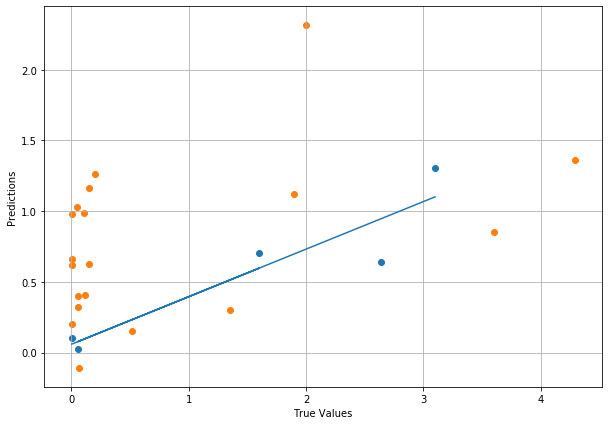

In [98]:
# Define PLS object
pls = PLSRegression(n_components=3)
# Fit
pls.fit(Xn_train, y_train)

y_pred = pls.predict(Xn_test)
y_pred1 = pls.predict(Xn_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using SNV

In [99]:
Xs_train = snv(X_train)
Xs_test = snv(X_test)
print(Xs_train.shape)
print(Xs_test.shape)

#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xs_train,y_train, 7, plot_components=True)

(19, 3)
(5, 3)


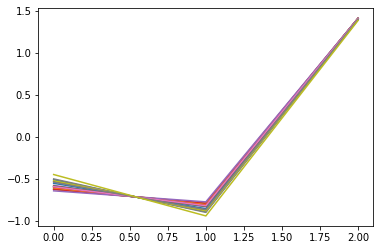

In [100]:
plt.plot(Xs_train.T)
plt.show()

R2_pred:  -0.2618014391920187
RMSE:  1.4365374570347698

TEST
 [real, predictions]
[[3.1        1.34540072]
 [2.636      0.66015624]
 [0.056      0.99443752]
 [1.6        0.85208185]
 [0.0054     1.38219904]]



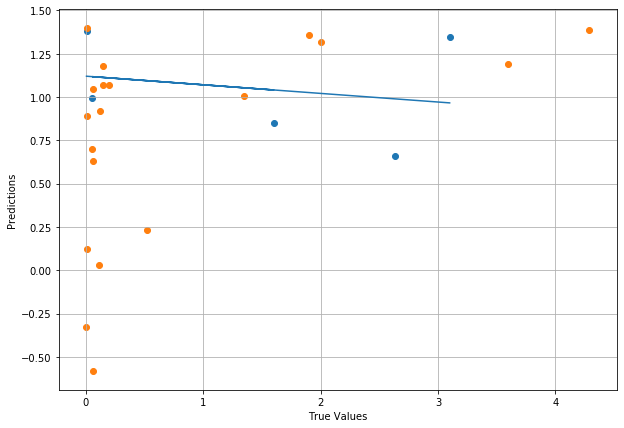

In [102]:
# Define PLS object
pls = PLSRegression(n_components=3)
# Fit
pls.fit(Xs_train, y_train)

y_pred = pls.predict(Xs_test)
y_pred1 = pls.predict(Xs_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Max-norm

In [48]:
Xm_train = X_train / np.max(X_train)
Xm_test = X_test / np.max(X_test)

#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xm_train,y_train, 7, plot_components=True)

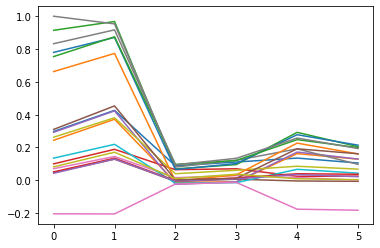

In [49]:
plt.plot(Xm_train.T)
plt.show()

R2_pred:  -53.5962516518032
RMSE:  6.633727384699091

TEST
 [real, predictions]
[[ 0.39        5.32805145]
 [ 0.293      10.22285858]
 [ 0.025       5.71624577]
 [ 2.48        7.81500291]
 [ 0.32        6.33603832]]



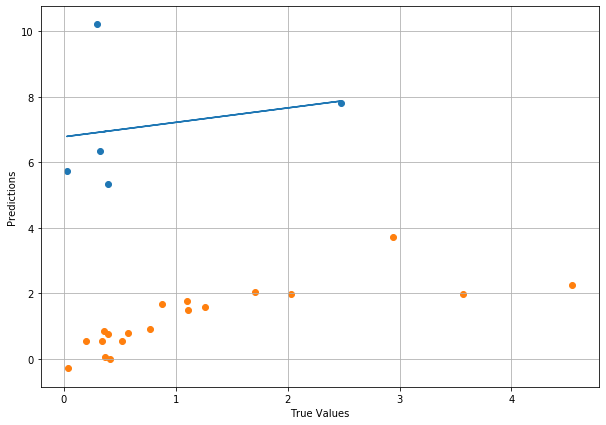

In [51]:
# Define PLS object
pls = PLSRegression(n_components=6)
# Fit
pls.fit(Xm_train, y_train)

y_pred = pls.predict(Xm_test)
y_pred1 = pls.predict(Xm_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Savgol filter

In [80]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1446) (19, 1)
(5, 1446) (5, 1)


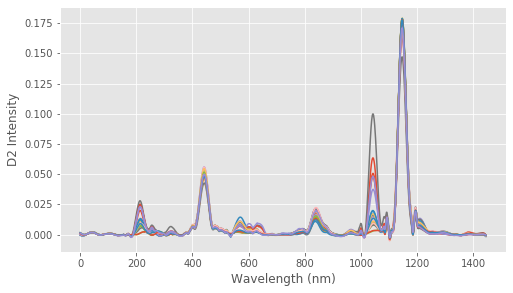

100% completed
Suggested number of components:  3



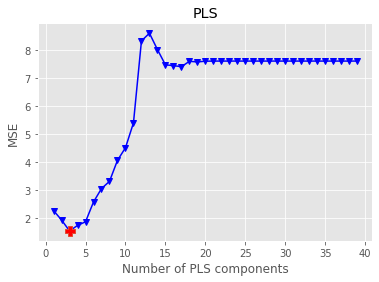

R2 calib: 0.476
R2 CV: -0.131
MSE calib: 0.716
MSE CV: 1.544


In [81]:
# Calculate second derivative
X2 = savgol_filter(x_df, 101, polyorder = 6,deriv=0) # Is this useful with LIBS spectra???
# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(range(len(X2.T)), X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Intensity')
    plt.show()
    
    
X2_1 = msc(X2)[0]
    
optimise_pls_cv(X2_1, y_df, 40, plot_components=True)

100% completed
Suggested number of components:  2



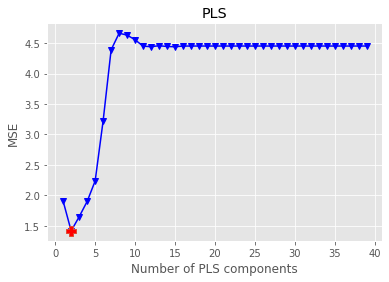

R2 calib: 0.620
R2 CV: -0.120
MSE calib: 0.481
MSE CV: 1.417


In [86]:
X2_train = savgol_filter(X_train, 37, polyorder = 4,deriv=1) 
X2_test = savgol_filter(X_test, 35, polyorder = 4,deriv=1) 




optimise_pls_cv(X2_train, y_train, 40, plot_components=True)

R2_pred:  -0.4142851041406448
R2_cv:  -0.502517109222492

[real, predictions]
[[ 0.339      -0.72308828]
 [ 3.57        0.70202523]
 [ 0.2         0.71243987]
 [ 0.293       1.80524588]
 [ 0.363      -0.11310216]]


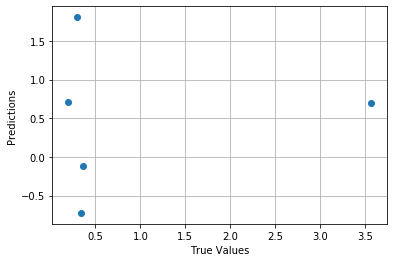

In [87]:
# Define PLS object
pls = PLSRegression(n_components=4)
# Fit
pls.fit(X2_train, y_train)

y_pred = pls.predict(X2_test)

# Cross-validation
y_cv = cross_val_predict(pls, X2_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Elastic Net

In [165]:
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.15)

alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

In [153]:
for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.70, MSE:3.55, RMSE:1.88
Alpha:0.0010, R2:0.48, MSE:1.06, RMSE:1.03
Alpha:0.0100, R2:0.14, MSE:0.72, RMSE:0.85
Alpha:0.1000, R2:0.00, MSE:0.79, RMSE:0.89
Alpha:0.3000, R2:0.00, MSE:0.79, RMSE:0.89
Alpha:0.5000, R2:0.00, MSE:0.79, RMSE:0.89
Alpha:0.7000, R2:0.00, MSE:0.79, RMSE:0.89
Alpha:1.0000, R2:0.00, MSE:0.79, RMSE:0.89


Train score:  0.6962327058883481
RMSE:  1.8849418494725623
R^2_pred:  -9.759667826663778 



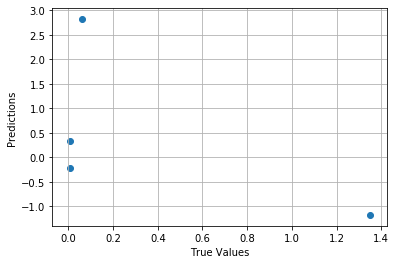

In [154]:
model = ElasticNet(alpha=0.0001).fit(X_train,y_train)   
score = model.score(X_train, y_train)
print("Train score: ", score)
pred_y = model.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, pred_y))
r2 = r2_score(y_test, pred_y)
print("RMSE: ", rmse)
print("R^2_pred: ", r2, "\n")

plt.scatter(y_test, pred_y)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Random Forest

In [166]:
#X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.15)
#X_train, X_test, y_train, y_test = train_test_split(principalComponents, y_df, test_size=0.15)

X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.15)


print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(y_test)

(20, 39) (20, 1)
(4, 39) (4, 1)


In [167]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(4,)
(20,)


RMSE:  0.9718832819673224
R^2:  -0.3880977102439662 

[real, predictions]
[[2.         1.37648989]
 [0.15       0.6478177 ]
 [1.6        0.44121932]
 [0.2        1.54121903]]


Text(0, 0.5, 'Predictions')

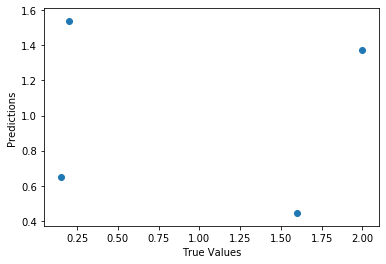

In [168]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 5000, max_depth=30, random_state = 42)
# Train the model on training data

rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("RMSE: ", rmse)
print("R^2: ", r2, "\n")

y_test= y_test.reshape((len(y_test), 1))
predictions=predictions.reshape((len(y_test), 1))
#print((y_test, predictions))

b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# MultiOutput Random Forest

In [169]:
multi_y = concentration[:,1:-2]
print (multi_y.shape)
print (type(multi_y))
df_y= pd.DataFrame(multi_y)
print (type(df_y))
df_y

(24, 6)
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5
0,0.185,0.228,2.940,0.0304,0.0620,0.280
1,0.360,0.600,1.100,0.0700,0.2000,0.830
2,9.140,1.010,0.200,0.4200,3.6000,0.410
3,8.565,0.000,0.293,0.8870,2.6360,0.330
4,9.500,0.000,0.391,0.0000,0.0580,0.016
5,7.220,0.140,0.360,0.0840,0.1200,0.053
6,7.460,0.530,0.036,0.1400,0.1500,0.100
7,12.900,0.120,0.520,0.1550,0.5200,0.286
8,8.750,0.460,1.710,0.0290,2.0000,0.056
9,0.260,0.420,1.260,0.0200,0.0040,1.160


In [201]:
X_train, X_test, y_train, y_test = train_test_split(x_df, df_y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(x_selecta, df_y, test_size=0.2, random_state= 16)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 39) (19, 6)
(5, 39) (5, 6)


In [202]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=2000,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=30,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=2000,
                                               

In [203]:
y_multirf = regr_multirf.predict(X_test)

In [204]:
print(y_test.shape)
print(y_multirf.shape)

(5, 6)
(5, 6)


In [205]:
rmse = sqrt(mean_squared_error(y_test, y_multirf))
r2 = r2_score(y_test, y_multirf)

print("R^2: ", r2)
print("RMSE: ", rmse)

R^2:  -0.8206633138505168
RMSE:  2.590681957654227


In [206]:
print("real: ", y_test[0].values)
print("pred: ", y_pred[:,0])

real:  [ 9.46   8.565 12.53   0.18   6.12 ]
pred:  [4.36412765 5.90128188 5.55766009 3.9239654  5.12038334]


# PLS-2

75% completed
Suggested number of components:  1



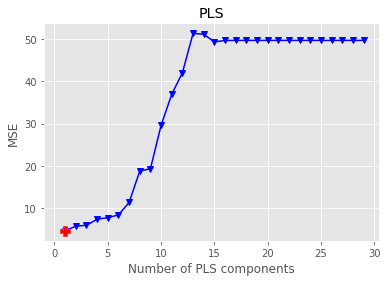

R2 calib: 0.113
R2 CV: -0.188
MSE calib: 3.611
MSE CV: 4.709


In [207]:
optimise_pls_cv(X_train, y_train, 30, plot_components=True)

In [208]:
# Define PLS object
pls = PLSRegression(n_components= 3)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ",score_pred) #NAMMERDA
print(score_cv)

R2_pred:  -1.3194544760170335
-0.640911679143935


In [209]:
pd.DataFrame(np.round(y_pred, decimals=2))

,0,1,2,3,4,5
0,3.84,0.42,0.97,1.31,1.43,0.36
1,3.72,0.60,1.61,0.18,1.40,0.39
2,3.42,0.37,1.24,1.20,1.17,0.43
3,5.75,0.04,0.88,-0.47,-0.65,0.48
4,5.54,0.10,0.74,0.04,-0.21,0.44


In [210]:
np.round(y_test, decimals=2)

,0,1,2,3,4,5
17,9.46,1.19,0.39,0.16,3.10,0.26
3,8.56,0.00,0.29,0.89,2.64,0.33
13,12.53,0.31,0.02,0.05,0.06,0.03
21,0.18,0.20,2.48,5.44,1.60,0.08
12,6.12,0.00,0.32,0.00,0.01,0.02
